In [0]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns
sns.set()

from scipy.stats import chisquare
from sklearn.svm import SVR
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.metrics import (accuracy_score, precision_score, recall_score, roc_auc_score, explained_variance_score, median_absolute_error,
                             f1_score,average_precision_score, confusion_matrix, mean_absolute_error, mean_squared_error, r2_score)
from xgboost import XGBClassifier, plot_importance, XGBRegressor
from sklearn.preprocessing import MinMaxScaler, StandardScaler, Imputer, LabelEncoder

In [0]:
from google.colab import files

uploaded = files.upload()

for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))

Saving dengue_features_test.csv to dengue_features_test.csv
Saving dengue_features_train.csv to dengue_features_train.csv
Saving dengue_labels_train.csv to dengue_labels_train.csv
Saving submission_format.csv to submission_format.csv
User uploaded file "dengue_features_test.csv" with length 82465 bytes
User uploaded file "dengue_features_train.csv" with length 287139 bytes
User uploaded file "dengue_labels_train.csv" with length 19582 bytes
User uploaded file "submission_format.csv" with length 5369 bytes


In [0]:
train = pd.read_csv("dengue_features_train.csv")
test = pd.read_csv("dengue_features_test.csv")
train_label = pd.read_csv("dengue_labels_train.csv")
submission_format = pd.read_csv("submission_format.csv")

In [0]:
full_data = pd.concat([train, test], ignore_index=True)

In [0]:
full_data.describe()

year   weekofyear      ndvi_ne      ndvi_nw      ndvi_se  \
count  1872.000000  1872.000000  1635.000000  1809.000000  1849.000000   
mean   2003.194979    26.489316     0.138588     0.129713     0.204663   
std       6.292268    15.006319     0.146413     0.125082     0.075064   
min    1990.000000     1.000000    -0.463400    -0.456100    -0.015533   
25%    1999.000000    13.750000     0.035300     0.041225     0.153457   
50%    2004.000000    26.000000     0.127317     0.115200     0.197029   
75%    2008.000000    39.000000     0.252225     0.223360     0.250857   
max    2013.000000    53.000000     0.508357     0.649000     0.538314   

           ndvi_sw  precipitation_amt_mm  reanalysis_air_temp_k  \
count  1849.000000           1857.000000            1860.000000   
mean      0.202174             44.109278             298.727770   
std       0.085768             42.065868               1.387410   
min      -0.063457              0.000000             294.554286   
25%       0.141014              9.430000             297.678929   
50%       0.188229             36.640000             298.617143   
75%       0.248086             67.500000             299.891429   
max       0.546017            390.600000             302.200000   

       reanalysis_avg_temp_k  reanalysis_dew_point_temp_k        ...          \
count            1860.000000                  1860.000000        ...           
mean              299.253955                   295.284823        ...           
std                 1.272510                     1.528046        ...           
min               294.892857                   289.642857        ...           
25%               298.276786                   294.164643        ...           
50%               299.300000                   295.667143        ...           
75%               300.271429                   296.502857        ...           
max               303.328571                   298.450000        ...           

       reanalysis_precip_amt_kg_per_m2  reanalysis_relative_humidity_percent  \
count                       1860.00000                           1860.000000   
mean                          40.60128                             82.237158   
std                           44.70528                              7.203803   
min                            0.00000                             57.787143   
25%                           12.49250                             77.214643   
50%                           27.08000                             80.307143   
75%                           53.12500                             86.799286   
max                          570.50000                             98.610000   

       reanalysis_sat_precip_amt_mm  reanalysis_specific_humidity_g_per_kg  \
count                   1857.000000                            1860.000000   
mean                      44.109278                              16.786638   
std                       42.065868                               1.547336   
min                        0.000000                              11.715714   
25%                        9.430000                              15.590714   
50%                       36.640000                              17.137143   
75%                       67.500000                              18.028929   
max                      390.600000                              20.461429   

       reanalysis_tdtr_k  station_avg_temp_c  station_diur_temp_rng_c  \
count        1860.000000         1817.000000              1817.000000   
mean            4.952903           27.226651                 8.004112   
std             3.545887            1.281254                 2.205734   
min             1.357143           21.400000                 4.042857   
25%             2.357143           26.328571                 6.357143   
50%             2.871429           27.433333                 7.200000   
75%             7.757143           28.200000                 9.625000   
max           

In [0]:
full_data.head()

city  year  weekofyear week_start_date   ndvi_ne   ndvi_nw   ndvi_se  \
0   sj  1990          18      1990-04-30  0.122600  0.103725  0.198483   
1   sj  1990          19      1990-05-07  0.169900  0.142175  0.162357   
2   sj  1990          20      1990-05-14  0.032250  0.172967  0.157200   
3   sj  1990          21      1990-05-21  0.128633  0.245067  0.227557   
4   sj  1990          22      1990-05-28  0.196200  0.262200  0.251200   

    ndvi_sw  precipitation_amt_mm  reanalysis_air_temp_k        ...          \
0  0.177617                 12.42             297.572857        ...           
1  0.155486                 22.82             298.211429        ...           
2  0.170843                 34.54             298.781429        ...           
3  0.235886                 15.36             298.987143        ...           
4  0.247340                  7.52             299.518571        ...           

   reanalysis_precip_amt_kg_per_m2  reanalysis_relative_humidity_percent  \
0                            32.00                             73.365714   
1                            17.94                             77.368571   
2                            26.10                             82.052857   
3                            13.90                             80.337143   
4                            12.20                             80.460000   

   reanalysis_sat_precip_amt_mm  reanalysis_specific_humidity_g_per_kg  \
0                         12.42                              14.012857   
1                         22.82                              15.372857   
2                         34.54                              16.848571   
3                         15.36                              16.672857   
4                          7.52                              17.210000   

   reanalysis_tdtr_k  station_avg_temp_c  station_diur_temp_rng_c  \
0           2.628571           25.442857                 6.900000   
1           2.371429           26.714286                 6.371429   
2           2.300000           26.714286                 6.485714   
3           2.428571           27.471429                 6.771429   
4           3.014286           28.942857                 9.371429   

   station_max_temp_c  station_min_temp_c  station_precip_mm  
0                29.4                20.0               16.0  
1                31.7                22.2                8.6  
2                32.2                22.8               41.4  
3                33.3                23.3                4.0  
4                35.0                23.9                5.8  

[5 rows x 24 columns]

In [0]:
full_data.columns

Index(['city', 'year', 'weekofyear', 'week_start_date', 'ndvi_ne', 'ndvi_nw',
       'ndvi_se', 'ndvi_sw', 'precipitation_amt_mm', 'reanalysis_air_temp_k',
       'reanalysis_avg_temp_k', 'reanalysis_dew_point_temp_k',
       'reanalysis_max_air_temp_k', 'reanalysis_min_air_temp_k',
       'reanalysis_precip_amt_kg_per_m2',
       'reanalysis_relative_humidity_percent', 'reanalysis_sat_precip_amt_mm',
       'reanalysis_specific_humidity_g_per_kg', 'reanalysis_tdtr_k',
       'station_avg_temp_c', 'station_diur_temp_rng_c', 'station_max_temp_c',
       'station_min_temp_c', 'station_precip_mm'],
      dtype='object')

In [0]:
print (train_label.head())
print(submission_format.head())

  city  year  weekofyear  total_cases
0   sj  1990          18            4
1   sj  1990          19            5
2   sj  1990          20            4
3   sj  1990          21            3
4   sj  1990          22            6
  city  year  weekofyear  total_cases
0   sj  2008          18            0
1   sj  2008          19            0
2   sj  2008          20            0
3   sj  2008          21            0
4   sj  2008          22            0


In [0]:
print (train["city"].equals(train_label["city"]))
print (train["year"].equals(train_label["year"]))
print (train["weekofyear"].equals(train_label["weekofyear"]))

True
True
True


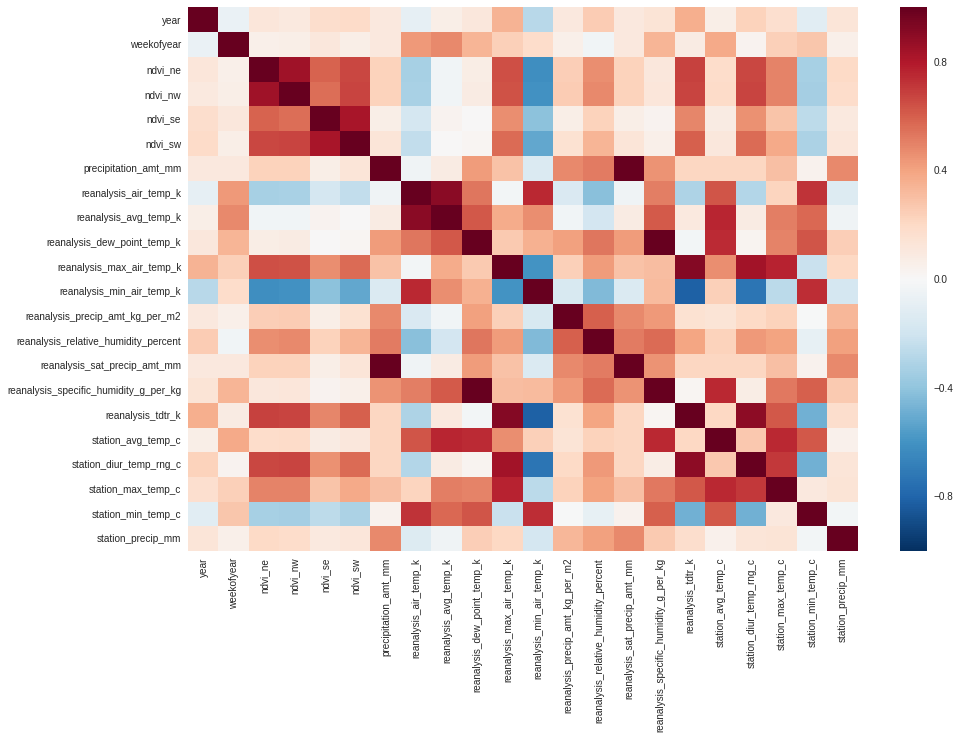

In [0]:
plt.subplots(figsize=(15,10))
sns.heatmap(full_data.corr())

In [0]:
# delete highly correlated feature
del full_data["precipitation_amt_mm"]
del full_data["reanalysis_dew_point_temp_k"]
del full_data["reanalysis_avg_temp_k"]
del full_data["reanalysis_tdtr_k"]

## Label Encoding

In [0]:
encoder = LabelEncoder()
full_data["week_start_date"] = encoder.fit_transform(full_data["week_start_date"])
full_data["city"] = encoder.fit_transform(full_data["city"])

In [0]:
full_data.isnull().sum()

city                                       0
year                                       0
weekofyear                                 0
week_start_date                            0
ndvi_ne                                  237
ndvi_nw                                   63
ndvi_se                                   23
ndvi_sw                                   23
reanalysis_air_temp_k                     12
reanalysis_max_air_temp_k                 12
reanalysis_min_air_temp_k                 12
reanalysis_precip_amt_kg_per_m2           12
reanalysis_relative_humidity_percent      12
reanalysis_sat_precip_amt_mm              15
reanalysis_specific_humidity_g_per_kg     12
station_avg_temp_c                        55
station_diur_temp_rng_c                   55
station_max_temp_c                        23
station_min_temp_c                        23
station_precip_mm                         27
dtype: int64

In [0]:
"""
full_data.rename(columns= {"week_start_date" :"w_s_d",
                           "reanalysis_air_temp_k" : "re_atk", 
                           "reanalysis_max_air_temp_k": "re_max_atk",
                           "reanalysis_min_air_temp_k" : "re_min_atk", 
                           "reanalysis_precip_amt_kg_per_m2" : "re_pre_akgpm2", 
                           "reanalysis_relative_humidity_percent" : "re_rhp", 
                           "reanalysis_sat_precip_amt_mm" : "re_sat_pam", 
                           "reanalysis_specific_humidity_g_per_kg" : "re_shgpkg",
                           "station_avg_temp_c" : "sta_atc",
                           "station_diur_temp_rng_c" : "sta_dtrc", 
                           "station_max_temp_c" :"sta_max_tc", 
                           "station_min_temp_c" : "sta_min_tc", 
                           "station_precip_mm" :"sta_pmm"}, inplace=True)
"""

'\nfull_data.rename(columns= {"week_start_date" :"w_s_d",\n                           "reanalysis_air_temp_k" : "re_atk", \n                           "reanalysis_max_air_temp_k": "re_max_atk",\n                           "reanalysis_min_air_temp_k" : "re_min_atk", \n                           "reanalysis_precip_amt_kg_per_m2" : "re_pre_akgpm2", \n                           "reanalysis_relative_humidity_percent" : "re_rhp", \n                           "reanalysis_sat_precip_amt_mm" : "re_sat_pam", \n                           "reanalysis_specific_humidity_g_per_kg" : "re_shgpkg",\n                           "station_avg_temp_c" : "sta_atc",\n                           "station_diur_temp_rng_c" : "sta_dtrc", \n                           "station_max_temp_c" :"sta_max_tc", \n                           "station_min_temp_c" : "sta_min_tc", \n                           "station_precip_mm" :"sta_pmm"}, inplace=True)\n'

### Imputation

In [0]:
missing_valued_feature = full_data.columns[4:]

impute = Imputer(missing_values='NaN', strategy='median', axis=0)
full_data[missing_valued_feature] = impute.fit_transform(full_data[missing_valued_feature])

## Checking Outliers

/usr/local/lib/python3.6/dist-packages/seaborn/categorical.py:454: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  box_data = remove_na(group_data)


(array([-250.,    0.,  250.,  500.,  750., 1000., 1250., 1500., 1750.,
        2000., 2250.]), <a list of 11 Text yticklabel objects>)

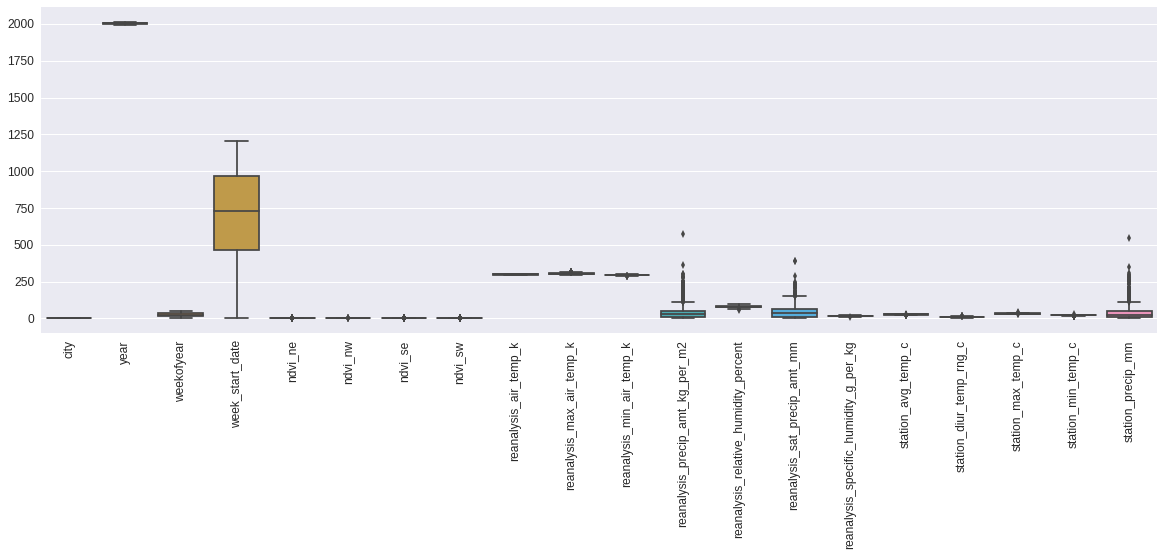

In [0]:
fig , ax = plt.subplots(figsize=(20,6))
sns.boxplot(data = full_data)
plt.xticks(fontsize=12, rotation=90)
plt.yticks(fontsize=12)

## Feature Scaling

In [0]:
scaler = MinMaxScaler()

scaled_data = scaler.fit_transform(full_data)
scaled_df = pd.DataFrame(data = scaled_data, columns = full_data.columns)
scaled_df.head()

city  year  weekofyear  week_start_date   ndvi_ne   ndvi_nw   ndvi_se  \
0   1.0   0.0    0.326923         0.000000  0.603031  0.506583  0.386418   
1   1.0   0.0    0.346154         0.000831  0.651706  0.541376  0.321190   
2   1.0   0.0    0.365385         0.001661  0.510055  0.569240  0.311879   
3   1.0   0.0    0.384615         0.002492  0.609240  0.634483  0.438912   
4   1.0   0.0    0.403846         0.003322  0.678770  0.649986  0.481601   

    ndvi_sw  reanalysis_air_temp_k  reanalysis_max_air_temp_k  \
0  0.395544               0.394806                   0.122699   
1  0.359233               0.478326                   0.190184   
2  0.384430               0.552877                   0.165644   
3  0.491150               0.579783                   0.220859   
4  0.509943               0.649290                   0.251534   

   reanalysis_min_air_temp_k  reanalysis_precip_amt_kg_per_m2  \
0                   0.708029                         0.056091   
1                   0.744526                         0.031446   
2                   0.810219                         0.045749   
3                   0.788321                         0.024365   
4                   0.824818                         0.021385   

   reanalysis_relative_humidity_percent  reanalysis_sat_precip_amt_mm  \
0                              0.381614                      0.031797   
1                              0.479668                      0.058423   
2                              0.594415                      0.088428   
3                              0.552387                      0.039324   
4                              0.555396                      0.019252   

   reanalysis_specific_humidity_g_per_kg  station_avg_temp_c  \
0                               0.262659            0.430091   
1                               0.418164            0.565350   
2                               0.586900            0.565350   
3                               0.566808            0.645897   
4                               0.628226            0.802432   

   station_diur_temp_rng_c  station_max_temp_c  station_min_temp_c  \
0                 0.243013            0.174194               0.464   
1                 0.198056            0.322581               0.640   
2                 0.207776            0.354839               0.688   
3                 0.232078            0.425806               0.728   
4                 0.453220            0.535484               0.776   

   station_precip_mm  
0           0.029450  
1           0.015829  
2           0.076201  
3           0.007362  
4           0.010676

/usr/local/lib/python3.6/dist-packages/seaborn/categorical.py:454: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  box_data = remove_na(group_data)


(array([-0.2,  0. ,  0.2,  0.4,  0.6,  0.8,  1. ,  1.2]),
 <a list of 8 Text yticklabel objects>)

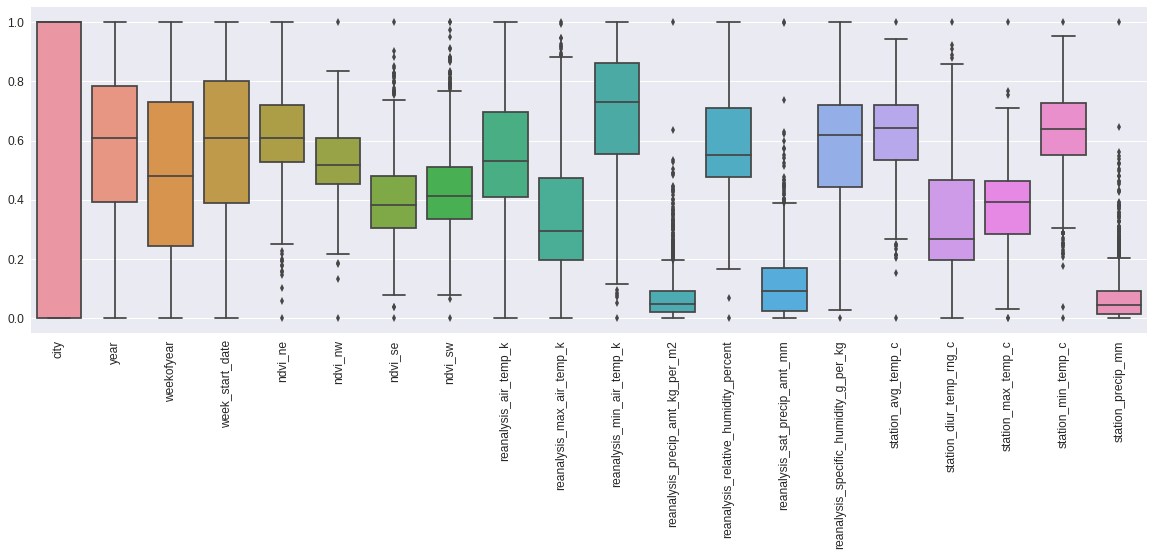

In [0]:
plt.subplots(figsize=(20,6))
sns.boxplot(data = scaled_df)
plt.xticks(fontsize=12, rotation=90)
plt.yticks(fontsize=12)

In [0]:
# detecting Outlier
# Inter Quartile Range is the distance between the 3rd Quartile and the first Qartile

minimum = 0
maximum = 0

def detect_outlier(feature):
    first_q = np.percentile(feature, 25)
    third_q = np.percentile(feature, 75) 
    IQR = third_q - first_q
    IQR *= 1.5
    minimum = first_q - IQR 
    maximum = third_q + IQR
    flag = False
    
    if(minimum > np.min(feature)):
        flag = True
    if(maximum < np.max(feature)):
        flag = True
    
    return flag

In [0]:
def  remove_outlier(feature):
    first_q = np.percentile(scaled_df[feature], 25)
    third_q = np.percentile(scaled_df[feature], 75)
    IQR = third_q - first_q
    IQR *= 1.5
    minimum = first_q - IQR 
    maximum = third_q + IQR
    
    mean = scaled_df[feature].median()
    
    scaled_df.loc[scaled_df[feature] < minimum, feature] = mean
    scaled_df.loc[scaled_df[feature] > maximum, feature] = mean

In [0]:
for i in range(len(scaled_df.columns)):
    if(detect_outlier(scaled_df[scaled_df.columns[i]])):
        print(scaled_df.columns[i], "Contains Outlier")

ndvi_ne Contains Outlier
ndvi_nw Contains Outlier
ndvi_se Contains Outlier
ndvi_sw Contains Outlier
reanalysis_max_air_temp_k Contains Outlier
reanalysis_min_air_temp_k Contains Outlier
reanalysis_precip_amt_kg_per_m2 Contains Outlier
reanalysis_relative_humidity_percent Contains Outlier
reanalysis_sat_precip_amt_mm Contains Outlier
reanalysis_specific_humidity_g_per_kg Contains Outlier
station_avg_temp_c Contains Outlier
station_diur_temp_rng_c Contains Outlier
station_max_temp_c Contains Outlier
station_min_temp_c Contains Outlier
station_precip_mm Contains Outlier


In [0]:
for k in range(15):
    for i in range(len(scaled_df.columns)):
        remove_outlier(scaled_df.columns[i])

/usr/local/lib/python3.6/dist-packages/seaborn/categorical.py:454: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  box_data = remove_na(group_data)


(array([-0.2,  0. ,  0.2,  0.4,  0.6,  0.8,  1. ,  1.2]),
 <a list of 8 Text yticklabel objects>)

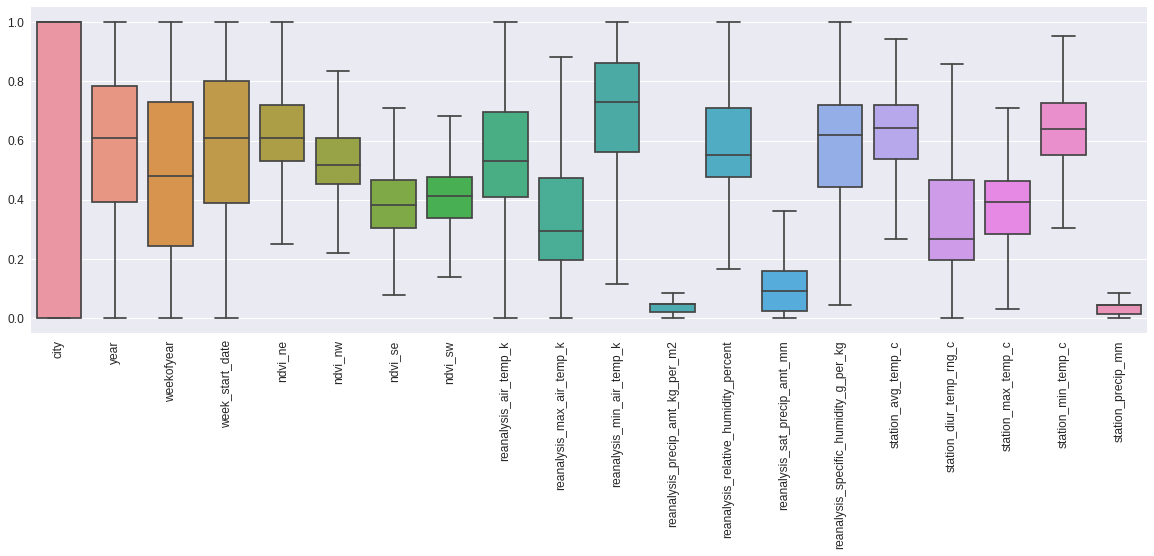

In [0]:
plt.subplots(figsize=(20,6))
sns.boxplot(data = scaled_df)
plt.xticks(fontsize=12, rotation=90)
plt.yticks(fontsize=12)

In [0]:
# year has strong correlation with weekofyear
del scaled_df["year"]

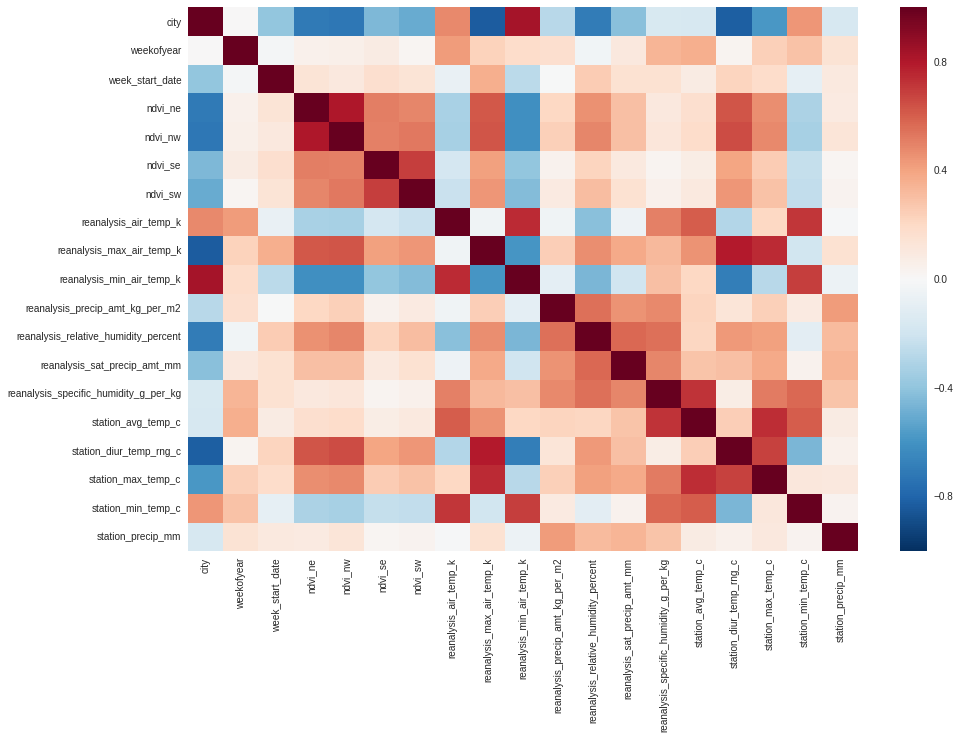

In [0]:
plt.subplots(figsize=(15,10))
sns.heatmap(scaled_df.corr())

In [0]:
scaled_df.columns

Index(['city', 'weekofyear', 'week_start_date', 'ndvi_ne', 'ndvi_nw',
       'ndvi_se', 'ndvi_sw', 'reanalysis_air_temp_k',
       'reanalysis_max_air_temp_k', 'reanalysis_min_air_temp_k',
       'reanalysis_precip_amt_kg_per_m2',
       'reanalysis_relative_humidity_percent', 'reanalysis_sat_precip_amt_mm',
       'reanalysis_specific_humidity_g_per_kg', 'station_avg_temp_c',
       'station_diur_temp_rng_c', 'station_max_temp_c', 'station_min_temp_c',
       'station_precip_mm'],
      dtype='object')

In [0]:
result = pd.DataFrame(columns=["Features", "Chi2Weights"])

for i in range(len(scaled_df.columns)):
    chi2, p = chisquare(scaled_df[scaled_df.columns[i]])
    result = result.append([pd.Series([scaled_df.columns[i], chi2], index = result.columns)], ignore_index=True)

In [0]:
pd.set_option("max_column", None)
result = result.sort_values(by="Chi2Weights", ascending=False)
result

Features  Chi2Weights
0                                    city   676.000000
1                              weekofyear   317.878119
2                         week_start_date   238.609042
8               reanalysis_max_air_temp_k   198.359567
15                station_diur_temp_rng_c   187.475465
12           reanalysis_sat_precip_amt_mm   139.231383
7                   reanalysis_air_temp_k   112.166591
13  reanalysis_specific_humidity_g_per_kg    99.138690
11   reanalysis_relative_humidity_percent    95.600282
9               reanalysis_min_air_temp_k    93.267670
16                     station_max_temp_c    76.024634
5                                 ndvi_se    71.699146
3                                 ndvi_ne    55.165340
6                                 ndvi_sw    52.216300
14                     station_avg_temp_c    51.032904
4                                 ndvi_nw    41.816317
17                     station_min_temp_c    41.712546
18                      station_precip_mm    22.755717
10        reanalysis_precip_amt_kg_per_m2    19.617757

In [0]:
X = scaled_df.iloc[0:1456, :]
y = train_label["total_cases"]
test = scaled_df.iloc[1456:, :]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)
#clf = LinearRegression()
#pred = clf.fit(X_train, y_train).predict(X_test)

## With Optimized Feature

In [0]:
kfold = KFold(n_splits=10, random_state=7)
model = LinearRegression()
scoring = 'neg_mean_absolute_error'
results = cross_val_score(model, X_train, y_train, cv=kfold, scoring=scoring)
print("Mean Absolute Error: %.3f (%.3f)"% (results.mean(), results.std()))

Mean Absolute Error: -18.797 (1.630)


In [0]:
kfold = KFold(n_splits=10, random_state=7)
model = LinearRegression()
scoring = 'neg_mean_absolute_error'
results = cross_val_score(model, X_train, y_train, cv=kfold, scoring=scoring)
print("Mean Absolute Error: %.3f (%.3f)"% (results.mean(), results.std()))

scoring = 'r2'
results = cross_val_score(model, X_train, y_train, cv=kfold, scoring=scoring)
print("r^2 metric: %.3f (%.3f)"% (results.mean(), results.std()))

scoring = 'neg_median_absolute_error'
results = cross_val_score(model, X_train, y_train, cv=kfold, scoring=scoring)
print("Median Abosolute error: %.3f (%.3f)"% (results.mean(), results.std()))

scoring = 'explained_variance'
results = cross_val_score(model, X_train, y_train, cv=kfold, scoring=scoring)
print("explained_variance score: %.3f (%.3f)"% (results.mean(), results.std()))

scoring = 'neg_mean_squared_error'
results = cross_val_score(model, X_train, y_train, cv=kfold, scoring=scoring)
print("Mean Squared Error: %.3f (%.3f)"% (results.mean(), results.std()))

Mean Absolute Error: -18.797 (1.630)
r^2 metric: 0.134 (0.059)
Median Abosolute error: -12.302 (1.302)
explained_variance score: 0.142 (0.053)
Mean Squared Error: -1316.491 (600.914)


### Experiment Result for SVR (rbf) kernel on 10 fold cross validation

In [0]:
svr_rbf = SVR(kernel='rbf', C=1e3, gamma=0.1)

scoring = 'explained_variance'
results = cross_val_score(svr_rbf, X_train, y_train, cv=kfold, scoring=scoring)
print("explained_variance score: %.3f (%.3f)"% (results.mean(), results.std()))

scoring = 'r2'
results = cross_val_score(svr_rbf, X_train, y_train, cv=kfold, scoring=scoring)
print("r^2 metric: %.3f (%.3f)"% (results.mean(), results.std()))


scoring = 'neg_mean_absolute_error'
results = cross_val_score(svr_rbf, X_train, y_train, cv=kfold, scoring=scoring)
print("Mean Absolute Error: %.3f (%.3f)"% (results.mean(), results.std()))

scoring = 'neg_mean_squared_error'
results = cross_val_score(svr_rbf, X_train, y_train, cv=kfold, scoring=scoring)
print("Mean Squared Error: %.3f (%.3f)"% (results.mean(), results.std()))

scoring = 'neg_median_absolute_error'
results = cross_val_score(svr_rbf, X_train, y_train, cv=kfold, scoring=scoring)
print("Median absolute Error: %.3f (%.3f)"% (results.mean(), results.std()))

explained_variance score: 0.219 (0.056)
r^2 metric: 0.180 (0.056)
Mean Absolute Error: -14.235 (2.120)
Mean Squared Error: -1304.378 (676.237)
Median absolute Error: -5.995 (0.884)


### Experiment Result for SVR (poly) kernel on 10 fold cross validation

In [0]:
svr_poly = SVR(kernel='poly', C=1e3, degree=2)

scoring = 'explained_variance'
results = cross_val_score(svr_poly, X_train, y_train, cv=kfold, scoring=scoring)
print("explained_variance score: %.3f (%.3f)"% (results.mean(), results.std()))

scoring = 'r2'
results = cross_val_score(svr_poly, X_train, y_train, cv=kfold, scoring=scoring)
print("r^2 metric: %.3f (%.3f)"% (results.mean(), results.std()))


scoring = 'neg_mean_absolute_error'
results = cross_val_score(svr_poly, X_train, y_train, cv=kfold, scoring=scoring)
print("Mean Absolute Error: %.3f (%.3f)"% (results.mean(), results.std()))

scoring = 'neg_mean_squared_error'
results = cross_val_score(svr_poly, X_train, y_train, cv=kfold, scoring=scoring)
print("Mean Squared Error: %.3f (%.3f)"% (results.mean(), results.std()))

scoring = 'neg_median_absolute_error'
results = cross_val_score(svr_poly, X_train, y_train, cv=kfold, scoring=scoring)
print("Median absolute Error: %.3f (%.3f)"% (results.mean(), results.std()))

explained_variance score: 0.183 (0.042)
r^2 metric: 0.132 (0.041)
Mean Absolute Error: -14.743 (2.049)
Mean Squared Error: -1367.338 (690.343)
Median absolute Error: -5.883 (0.447)


### Experiment Result for SVR (linear) kernel on 10 fold cross validation

In [0]:
svr_lin = SVR(kernel='linear', C=1e3)

scoring = 'explained_variance'
results = cross_val_score(svr_lin, X_train, y_train, cv=kfold, scoring=scoring)
print("explained_variance score: %.3f (%.3f)"% (results.mean(), results.std()))

scoring = 'r2'
results = cross_val_score(svr_lin, X_train, y_train, cv=kfold, scoring=scoring)
print("r^2 metric: %.3f (%.3f)"% (results.mean(), results.std()))


scoring = 'neg_mean_absolute_error'
results = cross_val_score(svr_lin, X_train, y_train, cv=kfold, scoring=scoring)
print("Mean Absolute Error: %.3f (%.3f)"% (results.mean(), results.std()))

scoring = 'neg_mean_squared_error'
results = cross_val_score(svr_lin, X_train, y_train, cv=kfold, scoring=scoring)
print("Mean Squared Error: %.3f (%.3f)"% (results.mean(), results.std()))

scoring = 'neg_median_absolute_error'
results = cross_val_score(svr_lin, X_train, y_train, cv=kfold, scoring=scoring)
print("Median absolute Error: %.3f (%.3f)"% (results.mean(), results.std()))

explained_variance score: 0.135 (0.026)
r^2 metric: 0.089 (0.030)
Mean Absolute Error: -15.971 (2.097)
Mean Squared Error: -1430.016 (712.680)
Median absolute Error: -7.496 (0.607)


In [0]:
clf = XGBRegressor(objective ='reg:linear', colsample_bytree = 0.3, learning_rate = 0.1,
                max_depth = 10, alpha = 10, n_estimators = 10)
clf.fit(X, y)
pred = clf.predict(X)
print(mean_absolute_error(pred, y))
print(mean_squared_error(pred, y))
print(median_absolute_error(pred, y))
print(r2_score(y, pred))

11.09318962879479
643.992885859476
3.6488771438598633
0.6609325029723618


In [0]:
clf_lr = LinearRegression()
pred_lr = clf_lr.fit(X_train, y_train).predict(X_test)

pred_xgbr = clf.predict(X_test)

clf_svr = SVR()
clf_svr.fit(X_train, y_train)
pred_svr = clf_svr.predict(X_test)

In [0]:
from sklearn.metrics import roc_curve, auc

fpr_1, tpr_1, _ = roc_curve(y_test, pred_lr)
fpr_2, tpr_2, _ = roc_curve(y_test, pred_xgbr)
fpr_3, tpr_3, _ = roc_curve(y_test, pred_svr)

roc_auc = dict()

roc_auc[0] = auc(fpr_1, tpr_1)
roc_auc[1] = auc(fpr_2, tpr_2)
roc_auc[2] = auc(fpr_3, tpr_3)

sns.set_style("white")
plt.figure(figsize=(10, 6))

plt.plot(fpr_1, tpr_1, color = "deeppink" , label = "Linear Regression - %0.2f" % roc_auc[0], lw=3)
plt.plot(fpr_2, tpr_2, color = "orange" , label = "XGBRegressor - %0.2f" % roc_auc[1], lw=3)
plt.plot(fpr_3, tpr_3, color = "#4caf50" , label = "Support Vector Regressor - %0.2f" % roc_auc[2], lw=3)

plt.plot([0, 1], [0, 1], color='red', lw=2, linestyle='--')
plt.xlabel('False Positive Rate', fontsize=16)
plt.ylabel('True Positive Rate', fontsize=16)
plt.title('Ion Channel - MSF+PSSM-Bigram', fontsize=22)
plt.legend(loc="lower right", fontsize=14)
plt.xticks(fontsize=13)
plt.yticks(fontsize=13)
plt.show()


Text(0,0.5,'Features')

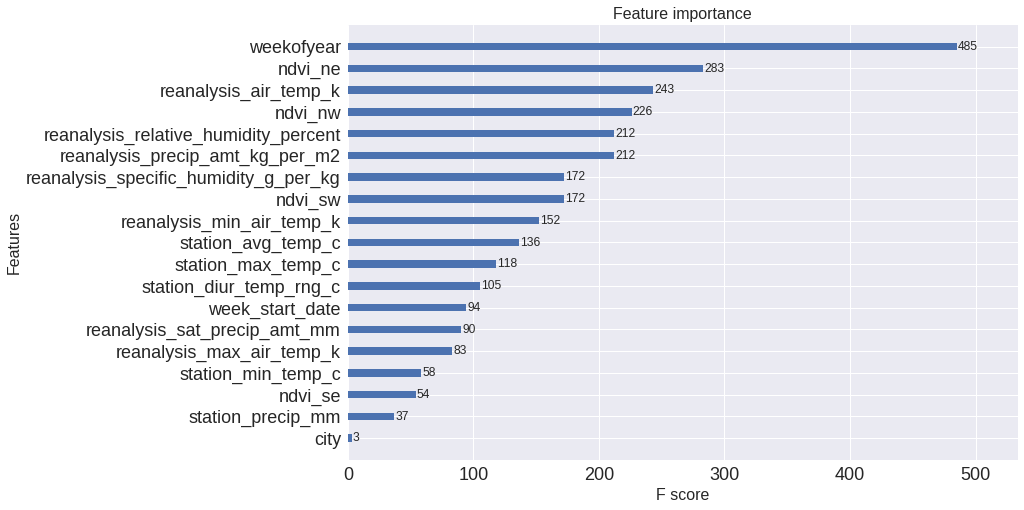

In [0]:
_, ax = plt.subplots(figsize=(12,8))
plot_importance(clf, ax, height=0.35)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.title("Feature importance", fontsize=16)
plt.xlabel("F score", fontsize=16)
plt.ylabel("Features", fontsize=16)

In [0]:
clf  = XGBClassifier(max_depth = 10, random_state = 7, n_estimators=220, eval_metric = 'auc', min_child_weight = 3,
                    colsample_bytree = 0.75, subsample= 0.8)
clf.fit(X, y)

pred = clf.predict(X)
print("Accuracy:", accuracy_score(y, pred))
print("Precision:", precision_score(y, pred, average="weighted"))
print("Recall:", recall_score(y, pred,  average="weighted"))
print("F1:", f1_score(y, pred, average="weighted"))

Accuracy: 0.9175824175824175
Precision: 0.8764909049207801
Recall: 0.9175824175824175
F1: 0.8917668975234627


/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


## With Reduced Feature

In [0]:
reduce_features_name = ["city", "weekofyear", "week_start_date", "reanalysis_max_air_temp_k", "station_diur_temp_rng_c", "reanalysis_sat_precip_amt_mm", 
                        "reanalysis_air_temp_k", "reanalysis_specific_humidity_g_per_kg", "reanalysis_relative_humidity_percent", "reanalysis_min_air_temp_k"]

reduced_feature = X[reduce_features_name]

In [0]:
X = reduced_feature

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

In [0]:
kfold = KFold(n_splits=10, random_state=0)
model = LinearRegression()
scoring = 'neg_mean_absolute_error'
results = cross_val_score(model, X_train, y_train, cv=kfold, scoring=scoring)
print("Mean Absolute Error: %.3f (%.3f)"% (results.mean(), results.std()))

scoring = 'r2'
results = cross_val_score(model, X_train, y_train, cv=kfold, scoring=scoring)
print("r^2 metric: %.3f (%.3f)"% (results.mean(), results.std()))

scoring = 'neg_median_absolute_error'
results = cross_val_score(model, X_train, y_train, cv=kfold, scoring=scoring)
print("Median Abosolute error: %.3f (%.3f)"% (results.mean(), results.std()))

scoring = 'explained_variance'
results = cross_val_score(model, X_train, y_train, cv=kfold, scoring=scoring)
print("explained_variance score: %.3f (%.3f)"% (results.mean(), results.std()))

scoring = 'neg_mean_squared_error'
results = cross_val_score(model, X_train, y_train, cv=kfold, scoring=scoring)
print("Mean Squared Error: %.3f (%.3f)"% (results.mean(), results.std()))

Mean Absolute Error: -18.446 (1.521)
r^2 metric: 0.144 (0.071)
Median Abosolute error: -11.825 (1.521)
explained_variance score: 0.152 (0.066)
Mean Squared Error: -1300.835 (605.171)


## SVM.SVR with Reduced Feature
### rbf kernel

In [0]:
svr_rbf = SVR(kernel='rbf', C=1e3, gamma=0.1)

scoring = 'explained_variance'
results = cross_val_score(svr_rbf, X_train, y_train, cv=kfold, scoring=scoring)
print("explained_variance score: %.3f (%.3f)"% (results.mean(), results.std()))

scoring = 'r2'
results = cross_val_score(svr_rbf, X_train, y_train, cv=kfold, scoring=scoring)
print("r^2 metric: %.3f (%.3f)"% (results.mean(), results.std()))


scoring = 'neg_mean_absolute_error'
results = cross_val_score(svr_rbf, X_train, y_train, cv=kfold, scoring=scoring)
print("Mean Absolute Error: %.3f (%.3f)"% (results.mean(), results.std()))

scoring = 'neg_mean_squared_error'
results = cross_val_score(model, X_train, y_train, cv=kfold, scoring=scoring)
print("Mean Squared Error: %.3f (%.3f)"% (results.mean(), results.std()))

scoring = 'neg_median_absolute_error'
results = cross_val_score(model, X_train, y_train, cv=kfold, scoring=scoring)
print("Median Absolute Error: %.3f (%.3f)"% (results.mean(), results.std()))

explained_variance score: 0.219 (0.054)
r^2 metric: 0.176 (0.053)
Mean Absolute Error: -14.214 (1.982)
Mean Squared Error: -1300.835 (605.171)
Median Absolute Error: -11.825 (1.521)


### linear kernel

In [0]:
svr_lin = SVR(kernel='linear', C=1e3)

scoring = 'explained_variance'
results = cross_val_score(svr_lin, X_train, y_train, cv=kfold, scoring=scoring)
print("explained_variance score: %.3f (%.3f)"% (results.mean(), results.std()))

scoring = 'r2'
results = cross_val_score(svr_lin, X_train, y_train, cv=kfold, scoring=scoring)
print("r^2 metric: %.3f (%.3f)"% (results.mean(), results.std()))


scoring = 'neg_mean_absolute_error'
results = cross_val_score(svr_lin, X_train, y_train, cv=kfold, scoring=scoring)
print("Mean Absolute Error: %.3f (%.3f)"% (results.mean(), results.std()))

scoring = 'neg_mean_squared_error'
results = cross_val_score(svr_lin, X_train, y_train, cv=kfold, scoring=scoring)
print("Mean Squared Error: %.3f (%.3f)"% (results.mean(), results.std()))

scoring = 'neg_median_absolute_error'
results = cross_val_score(svr_lin, X_train, y_train, cv=kfold, scoring=scoring)
print("Median Absolute Error: %.3f (%.3f)"% (results.mean(), results.std()))

explained_variance score: 0.137 (0.027)
r^2 metric: 0.089 (0.031)
Mean Absolute Error: -15.956 (2.128)
Mean Squared Error: -1429.727 (711.321)
Median Absolute Error: -7.279 (0.451)


### poly kernel

In [0]:
svr_poly = SVR(kernel='poly', C=1e3, degree=2)

scoring = 'explained_variance'
results = cross_val_score(svr_poly, X_train, y_train, cv=kfold, scoring=scoring)
print("explained_variance score: %.3f (%.3f)"% (results.mean(), results.std()))

scoring = 'r2'
results = cross_val_score(svr_poly, X_train, y_train, cv=kfold, scoring=scoring)
print("r^2 metric: %.3f (%.3f)"% (results.mean(), results.std()))


scoring = 'neg_mean_absolute_error'
results = cross_val_score(svr_poly, X_train, y_train, cv=kfold, scoring=scoring)
print("Mean Absolute Error: %.3f (%.3f)"% (results.mean(), results.std()))

scoring = 'neg_mean_squared_error'
results = cross_val_score(svr_poly, X_train, y_train, cv=kfold, scoring=scoring)
print("Mean Squared Error: %.3f (%.3f)"% (results.mean(), results.std()))

scoring = 'neg_median_absolute_error'
results = cross_val_score(svr_poly, X_train, y_train, cv=kfold, scoring=scoring)
print("Median Absolute Error: %.3f (%.3f)"% (results.mean(), results.std()))

explained_variance score: 0.194 (0.043)
r^2 metric: 0.147 (0.041)
Mean Absolute Error: -14.686 (1.990)
Mean Squared Error: -1342.409 (676.762)
Median Absolute Error: -6.062 (0.576)


In [0]:
clf  = XGBClassifier(max_depth = 10,random_state = 7, n_estimators=220, eval_metric = 'auc', min_child_weight = 3,
                    colsample_bytree = 0.75, subsample= 0.8)
clf.fit(X_train, y_train)

pred = clf.predict(X_train)
print("Accuracy:", accuracy_score(y_train, pred))
print("Precision:", precision_score(y_train, pred, average="weighted"))
print("Recall:", recall_score(y_train, pred,  average="weighted"))
print("F1:", f1_score(y_train, pred, average="weighted"))

Accuracy: 0.8788659793814433
Precision: 0.8194759935776844
Recall: 0.8788659793814433
F1: 0.8416195269655192


/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [0]:
clf = XGBRegressor(objective ='reg:linear', colsample_bytree = 0.3, learning_rate = 0.1,
                max_depth = 10, alpha = 10, n_estimators = 220)
clf.fit(X_train, y_train)
pred = clf.predict(X_test)
print(mean_absolute_error(pred, y_test))
print(mean_squared_error(pred, y_test))
print(median_absolute_error(pred, y_test))
print(r2_score(y_test, pred))

12.830715510228725
835.4546280284807
5.511565923690796
0.7397435539657125


Text(0,0.5,'Features')

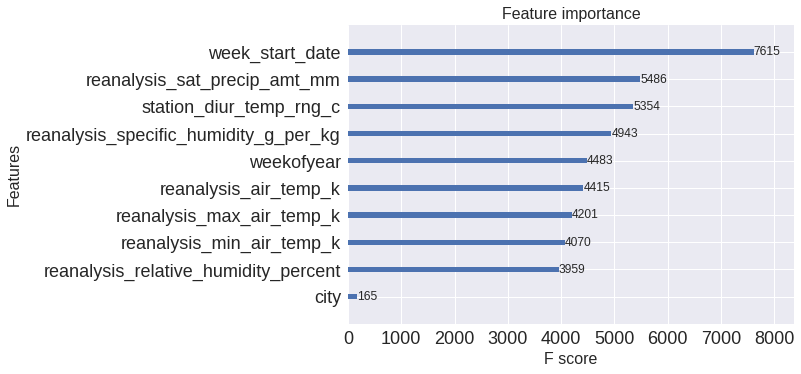

In [0]:
plot_importance(clf)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.title("Feature importance", fontsize=16)
plt.xlabel("F score", fontsize=16)
plt.ylabel("Features", fontsize=16)

In [0]:
confusion_matrix(y_train, pred, labels=[0,1])

array([[84,  0],
       [ 0, 50]])

In [0]:
test.shape, train.shape, full_data.shape

((416, 24), (1456, 24), (1872, 20))

In [0]:
test_pred = clf.predict(test)

In [0]:
#clf.predict(X_test)
sub_df = test.iloc[:, :3]

In [0]:
sub_df.insert(loc=3, column="total_cases", value=test_pred)

In [0]:
sub_df.to_csv('submission.csv', index=False)

In [0]:
files.download("submission.csv")

In [0]:
sub_df.head()

city  year  weekofyear  total_cases
0   sj  2008          18            9
1   sj  2008          19           10
2   sj  2008          20           17
3   sj  2008          21           16
4   sj  2008          22           15

In [0]:
sub_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 416 entries, 0 to 415
Data columns (total 4 columns):
city           416 non-null object
year           416 non-null int64
weekofyear     416 non-null int64
total_cases    416 non-null float32
dtypes: float32(1), int64(2), object(1)
memory usage: 11.5+ KB
